In [ ]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import os
from PIL import Image
from tqdm import tqdm_notebook, tnrange
from skimage.transform import resize
import cv2
import random
import keras
import re
import sys
from sklearn.model_selection import train_test_split

from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from tensorflow.keras.layers import Dense, Input, Dropout,Flatten, Conv2D, Conv2DTranspose, GlobalMaxPooling2D
from tensorflow.keras.layers import BatchNormalization, Activation, MaxPooling2D, GlobalMaxPooling2D
from tensorflow.keras.models import Model, Sequential, load_model, save_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import MeanIoU
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from keras.layers.merge import concatenate
import keras.backend as K

import tensorflow as tf
import tensorflow_datasets as tfds
print("Tensorflow version:", tf.__version__)

Tensorflow version: 2.4.1


In [ ]:
main='drive/My Drive/Project ACM - GPA'
data_dir='drive/My Drive/Project ACM - GPA/data'

print(len(os.listdir(os.path.join(data_dir,'Cat'))))
print(len(os.listdir(os.path.join(data_dir,'Dog'))))

500
500


#Continued

In [ ]:
print(os.listdir(data_dir))

['Cat', 'Dog']


In [ ]:
frame_gen_args = dict(rotation_range=15,
                      width_shift_range=0.1,
                      height_shift_range=0.1,
                      shear_range=0.2,
                      zoom_range=0.2,
                      horizontal_flip=True,
                      vertical_flip=True,
                      fill_mode='reflect',
                      validation_split= 0.2)

frame_datagen= ImageDataGenerator(**frame_gen_args)

In [ ]:
seed=1
batch_size = 20
height, width = 256, 320

In [ ]:
def Train_AugmentGenerator(seed=seed, batch_size = batch_size):
    '''Train Image data generator
        Inputs: 
            seed - seed provided to the flow_from_directory function to ensure aligned data flow
            batch_size - number of images to import at a time
        Output: Decoded RGB image (height x width x 3) 
    '''
    train_frame_generator = frame_datagen.flow_from_directory(
        data_dir,
        target_size=(height, width),
        batch_size=batch_size,
        subset='training',
        seed= seed) 
    
    while True:
        X1i = train_frame_generator.next()
        yield X1i[0], X1i[0]

In [ ]:
def Val_AugmentGenerator(seed = seed, batch_size = batch_size):
    '''Validation Image data generator
        Inputs: 
            seed - seed provided to the flow_from_directory function to ensure aligned data flow
            batch_size - number of images to import at a time
        Output: Decoded RGB image (height x width x 3) 
    '''
    val_frame_generator = frame_datagen.flow_from_directory(
        data_dir,
        target_size=(height,width),
        batch_size= batch_size,
        subset='validation',
        seed= seed)

    while True:
        X1i = val_frame_generator.next()
        # X2i = val_mask_generator.next()
        
        # #One hot encoding RGB images
        # mask_encoded = [rgb_to_onehot(X2i[0][x,:,:,:], id2code) for x in range(X2i[0].shape[0])]
        
        # yield X1i[0], np.asarray(mask_encoded)
        yield X1i[0], X1i[0]

In [ ]:
t_gen=Train_AugmentGenerator()
batch_img,batch_mask = next(t_gen)

Found 800 images belonging to 2 classes.


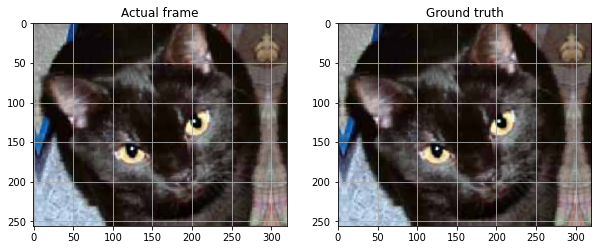

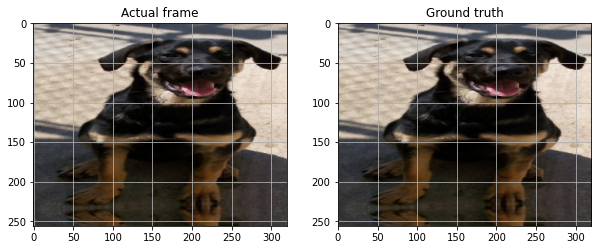

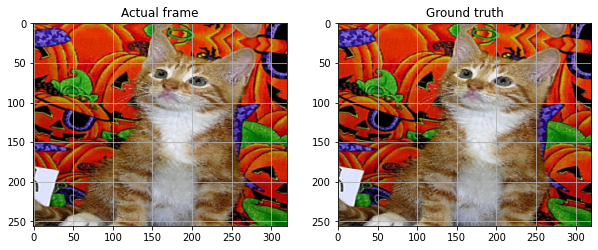

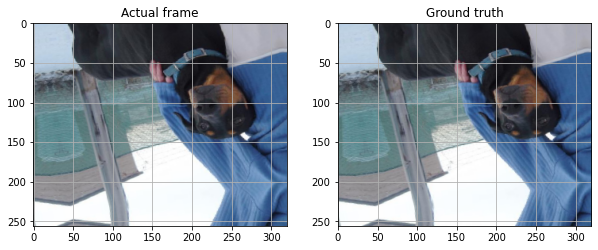

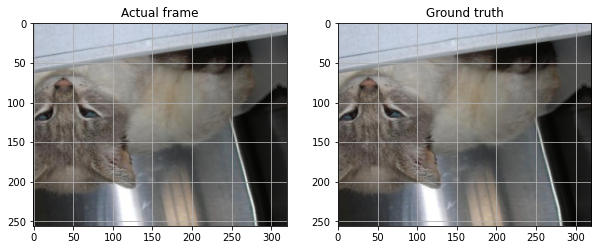

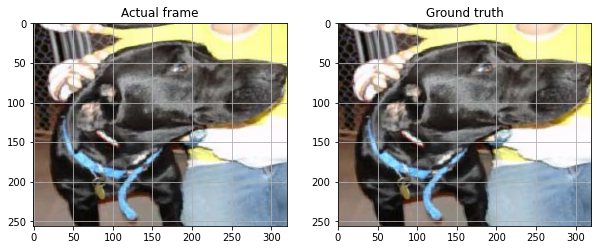

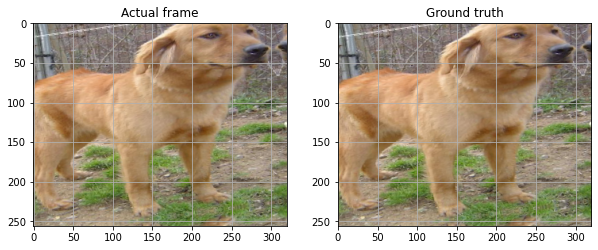

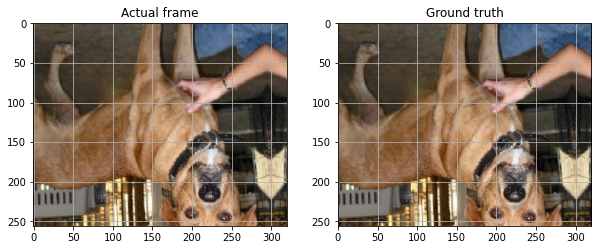

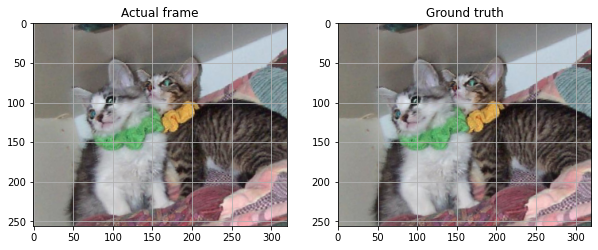

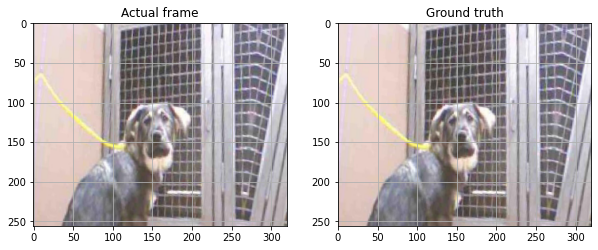

In [ ]:
for i in range(0,batch_size//2):
    
    fig = plt.figure(figsize=(10,4))
    
    ax1 = fig.add_subplot(1,2,1)
    ax1.set_title('Actual frame')
    ax1.imshow(batch_img[i].astype(int))
    ax1.grid(b=None)
    
    
    ax2 = fig.add_subplot(1,2,2)
    ax2.set_title('Ground truth')
    ax2.imshow(batch_mask[i].astype(int))
    ax2.grid(b=None)
    
    plt.show()

In [ ]:
def model_UNET(h,w,filters=40,pi=0.4):

  input_layer=Input(shape=(h,w,3))
  c1=Conv2D(filters*1, kernel_size=(3,3), padding='same', activation='relu')(input_layer)   
  c1=Conv2D(filters*1, kernel_size=(3,3), padding='same', activation='relu')(c1)      # 256,320,8
  c1=BatchNormalization()(c1)     # 256,320,8
  p1=MaxPooling2D(pool_size=(2,2), strides=2)(c1)   # 128,160,8
  p1=Dropout(rate=pi)(p1)         # 128,160,8

  c2=Conv2D(filters*2, kernel_size=(3,3), padding='same', activation='relu')(p1)      # 128,160,16
  c2=Conv2D(filters*2, kernel_size=(3,3), padding='same', activation='relu')(c2)      # 128,160,16
  c2=BatchNormalization()(c2)       # 128,160,16
  p2=MaxPooling2D(pool_size=(2,2), strides=2)(c2)   #64,80,16
  p2=Dropout(rate=pi)(p2)           # 64,80,16


  c3=Conv2D(filters*4, kernel_size=(3,3), padding='same', activation='relu')(p2)      # 64,80,32
  c3=Conv2D(filters*4, kernel_size=(3,3), padding='same', activation='relu')(c3)      # 64,60,32
  c3=BatchNormalization()(c3)        # 64,80,32
  p3=MaxPooling2D(pool_size=(2,2), strides=2)(c3)   #32,40,32
  p3=Dropout(rate=pi)(p3)            # 32,40,32


  c4=Conv2D(filters*8, kernel_size=(3,3), padding='same', activation='relu')(p3)      # 32,40,64
  c4=Conv2D(filters*8, kernel_size=(3,3), padding='same', activation='relu')(c4)      # 32,40,64
  c4=BatchNormalization()(c4)        # 32,40,64
  p4=MaxPooling2D(pool_size=(2,2), strides=2)(c4)   # 16,20,64
  p4=Dropout(rate=pi)(p4)            # 16,20,64

  c5=Conv2D(filters*16, kernel_size=(3,3), padding='same', activation='relu')(p4)      # 16,20,128
  c5=Conv2D(filters*16, kernel_size=(3,3), padding='same', activation='relu')(c5)      # 16,20,128
  c5=BatchNormalization()(c5)        # 16,20,128
  p5=MaxPooling2D(pool_size=(2,2), strides=2)(c5)   # 8,10,128
  p5=Dropout(rate=pi)(p5)            # 8,10,128

  c6=Conv2D(filters*32, kernel_size=(3,3), padding='same', activation='relu')(p5)     # 8,10,256
  c6=Conv2D(filters*32, kernel_size=(3,3), padding='same', activation='relu')(c6)     # 8,10,256
  c6=BatchNormalization()(c6)        # 8,10,256
  p6=MaxPooling2D(pool_size=(2,2), strides=2)(c6)   # 4,5,256
  p6=Dropout(rate=pi)(p6)            # 4,5,256


  u8= Conv2DTranspose(filters*16, kernel_size=(3,3), strides=(2,2), padding='same')(p6) # 8,10,128
  u8= concatenate([u8,p5])           # 8,10,256

  c7= Conv2D(filters*16, kernel_size=(3,3), padding='same', activation='relu')(u8)
  c7= Conv2D(filters*16, kernel_size=(3,3), padding='same', activation='relu')(c7)
  c7= BatchNormalization()(c7)
  c7= Dropout(rate=pi)(c7)

  u9= Conv2DTranspose(filters*8, kernel_size=(3,3), strides=(2,2), padding='same')(c7)
  u9= concatenate([u9,p4])

  c8= Conv2D(filters*8, kernel_size=(3,3), padding='same', activation='relu')(u9)
  c8= Conv2D(filters*8, kernel_size=(3,3), padding='same', activation='relu')(c8)
  c8= BatchNormalization()(c8)
  c8= Dropout(rate=pi)(c8)

  u10= Conv2DTranspose(filters*4, kernel_size=(3,3), strides=(2,2), padding='same')(c8)
  u10= concatenate([u10,p3])

  c9= Conv2D(filters*4, kernel_size=(3,3), padding='same', activation='relu')(u10)
  c9= Conv2D(filters*4, kernel_size=(3,3), padding='same', activation='relu')(c9)
  c9= BatchNormalization()(c9)
  c9= Dropout(rate=pi)(c9)

  u11= Conv2DTranspose(filters*2, kernel_size=(3,3), strides=(2,2), padding='same')(c9)
  u11= concatenate([u11,p2])

  c10= Conv2D(filters*2, kernel_size=(3,3), padding='same', activation='relu')(u11)
  c10= Conv2D(filters*2, kernel_size=(3,3), padding='same', activation='relu')(c10)
  c10= BatchNormalization()(c10)
  c10= Dropout(rate=pi)(c10)

  u12= Conv2DTranspose(filters*1, kernel_size=(3,3), strides=(2,2), padding='same')(c10)
  u12= concatenate([u12,p1])
  u12= Conv2DTranspose(filters*1, kernel_size=(3,3), strides=(2,2), padding='same')(u12)

  output= Conv2D(3, kernel_size=(1,1), padding='same', activation='relu')(u12)
  
  unet=Model(inputs=[input_layer], outputs=[output])
  return unet

In [ ]:
model= model_UNET(height,width)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 320, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 320, 40) 1120        input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 320, 40) 14440       conv2d[0][0]                     
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 256, 320, 40) 160         conv2d_1[0][0]                   
______________________________________________________________________________________________

In [ ]:
# def dice_coef(y_true, y_pred):
#     y_true_f = K.flatten(y_true)
#     y_pred_f = K.flatten(y_pred)
#     intersection = K.sum(y_true_f * y_pred_f)
#     return (2. * intersection + 1) / (K.sum(y_true_f) + K.sum(y_pred_f) + 1)

# def dice_coef_loss(y_true, y_pred):
#     return -1*dice_coef(y_true, y_pred)

def rev_loss(y_true, y_pred):
  beta=1.2;
  return beta *K.sqrt(K.sum(K.square(y_true - y_pred)))

def dice_coef(y_true, y_pred, smooth=1):
    intersection = K.sum(K.abs(y_true * y_pred), axis=-1)
    return (2. * intersection + smooth) / (K.sum(K.square(y_true),-1) + K.sum(K.square(y_pred),-1) + smooth)

def dice_coef_loss(y_true, y_pred):
    return 1-dice_coef(y_true, y_pred)

In [ ]:
opt=Adam(learning_rate=1e-3)
model.compile(optimizer=opt, loss= rev_loss, metrics=['accuracy',dice_coef])

In [ ]:
t_gen=Train_AugmentGenerator()
batch_img,batch_mask = next(t_gen)

v_gen=Val_AugmentGenerator()
batch_img1,batch_mask1 = next(v_gen)

Found 800 images belonging to 2 classes.
Found 200 images belonging to 2 classes.


In [ ]:
num_epochs = 20
total_train_ims=800
total_val_ims=200
steps_per_epoch= total_train_ims//batch_size
val_steps= total_val_ims//batch_size

In [ ]:
weights_file = os.path.join(main,'savedweights44.hdf5')

checkpoint = ModelCheckpoint(weights_file, monitor='val_loss', verbose=1, 
                             save_best_only=True, mode='min', save_weights_only = True)

reduceLROnPlat = ReduceLROnPlateau(monitor='val_loss', factor=0.1, 
                                   patience=7, 
                                   verbose=1, mode='min', min_lr=1e-9)
callbacks = [checkpoint, reduceLROnPlat]

In [ ]:
weights_file

'drive/My Drive/Project ACM - GPA/savedweights44.hdf5'

In [ ]:
model.load_weights(weights_file)

In [ ]:
history= model.fit(Train_AugmentGenerator(),
                   epochs= num_epochs,
                   callbacks= callbacks,
                   validation_data= Val_AugmentGenerator(),
                   shuffle= True,
                   steps_per_epoch= steps_per_epoch,
                   validation_steps= val_steps)

Found 800 images belonging to 2 classes.
Epoch 1/20
40/40 [==============================] - 198s 5s/step - loss: 39442.3750 - accuracy: 0.7881 - dice_coef: 0.9554 - val_loss: 20858.7695 - val_accuracy: 0.8649 - val_dice_coef: 0.9518

Epoch 00001: val_loss improved from inf to 20858.76953, saving model to drive/My Drive/Project ACM - GPA/savedweights44.hdf5
Epoch 2/20
40/40 [==============================] - 29s 719ms/step - loss: 36683.5508 - accuracy: 0.7907 - dice_coef: 0.9578 - val_loss: 16307.2188 - val_accuracy: 0.9078 - val_dice_coef: 0.9770

Epoch 00002: val_loss improved from 20858.76953 to 16307.21875, saving model to drive/My Drive/Project ACM - GPA/savedweights44.hdf5
Epoch 3/20
40/40 [==============================] - 29s 723ms/step - loss: 35001.9492 - accuracy: 0.7953 - dice_coef: 0.9616 - val_loss: 18784.6738 - val_accuracy: 0.8136 - val_dice_coef: 0.9860

Epoch 00003: val_loss did not improve from 16307.21875
Epoch 4/20
40/40 [==============================] - 28s 715m

In [ ]:
!mkdir -p saved_model
model.save(os.path.join(main,'savedmodel44.h5'))

#Testing

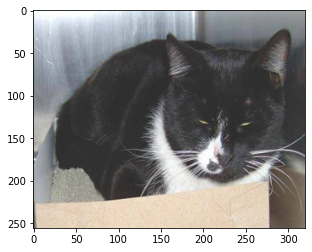

In [ ]:
img1=load_img(os.path.join(main,'dog.2005.jpg'),color_mode='rgb',target_size=(height,width),interpolation='bicubic')
img2=load_img(os.path.join(main,'cat.2001.jpg'),color_mode='rgb',target_size=(height,width),interpolation='bicubic')

img4=load_img(os.path.join(main,'sample.jpg'),color_mode='rgb',target_size=(height,width),interpolation='bicubic')
img3=load_img(os.path.join(main,'lena.jpg'),color_mode='rgb',target_size=(height,width),interpolation='bicubic')

img1= (np.asarray(img1).copy())/255.0
img2= (np.asarray(img2).copy())/255.0
img3= (np.asarray(img3).copy())/255.0
img4= (np.asarray(img4).copy())/255.0

plt.imshow(img2)

In [ ]:
arr1= array_to_img(img1)
arr2= array_to_img(img2)
arr3= array_to_img(img3)
arr4= array_to_img(img4)

test=np.zeros((4,height,width,3))
test[0]= arr1
test[1]= arr2
test[2]= arr3
test[3]= arr4
pred=model.predict(test)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


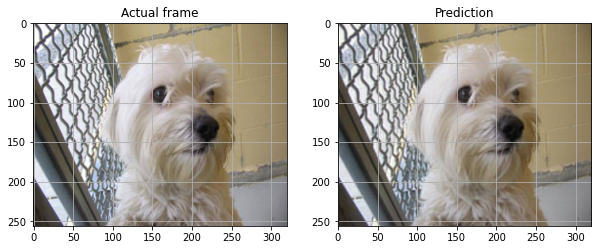

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


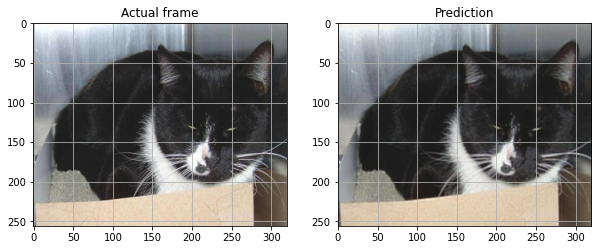

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


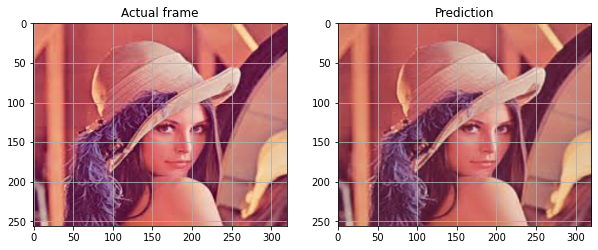

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


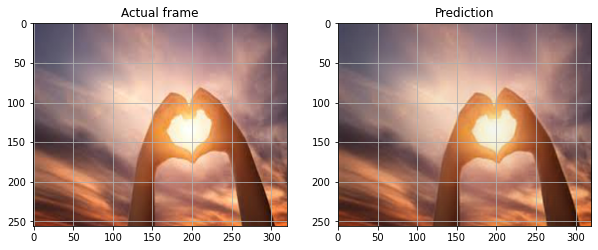

In [ ]:
for i in range(4):    
    fig = plt.figure(figsize=(10,4))
    
    ax1 = fig.add_subplot(1,2,1)
    ax1.set_title('Actual frame')
    ax1.imshow(test[i].astype(int))
    ax1.grid(b=None)
    
    
    ax2 = fig.add_subplot(1,2,2)
    ax2.set_title('Prediction')
    ax2.imshow(pred[i].astype(int))
    ax2.grid(b=None)
    
    plt.show()